In [1]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
%config InlineBackend.figure_format = 'svg'

__1.__  1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [2]:
# сгенерируем данные

classification_data, classification_labels = datasets.make_classification(n_samples=1000, n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0,
                                                                 flip_y=0.2,
                                                                 n_clusters_per_class=1, random_state=3)
  
X_train, X_test, y_train, y_test = train_test_split(classification_data,
                                                    classification_labels,
                                                    test_size=0.3,
                                                    random_state=1)

classification_data.shape

(1000, 2)

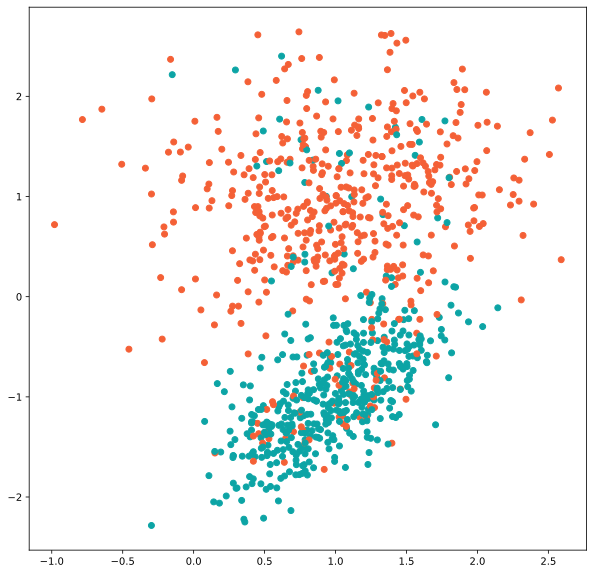

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['#F46036', '#0CA4A5'])
light_colors = ListedColormap(['#FAB29E', '#A0F8F8'])

plt.figure(figsize=(10, 10))
plt.scatter(classification_data[:, 0], classification_data[:, 1], 
              c=classification_labels, cmap=colors);

In [4]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
#     predictions = np.zeros(X.shape[0])
#     for i, x in enumerate(X):
#         prediction = 0
#         for alg in trees_list:
#             prediction += eta * alg.predict([x])[0]
#         predictions[i] = prediction
        
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

In [5]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [6]:
def residual(y, z):
    return - (z - y)

In [7]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [8]:
number_of_trees = list(range(1, 31))
max_depth = 2
eta = 0.05

mse_train_trees = []
mse_test_trees = []

for n_trees in number_of_trees:
  trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

  train_prediction = gb_predict(X_train, trees, eta)
  test_prediction = gb_predict(X_test, trees, eta)

  train_err = mean_squared_error(y_train, train_prediction)
  mse_train_trees.append(train_err)

  test_err = mean_squared_error(y_test, test_prediction)
  mse_test_trees.append(test_err)

mse_train_trees, mse_test_trees

([0.46352942482129256,
  0.42932350925275287,
  0.3984500607922963,
  0.37058181473864693,
  0.34542512933340136,
  0.3227181903711137,
  0.30222006344268393,
  0.28371574541220035,
  0.2670126785171622,
  0.2519335947423245,
  0.23832096005521575,
  0.22603282889413684,
  0.21493889060550725,
  0.20492301774987215,
  0.1958819908965225,
  0.18771796670569882,
  0.18034159242366243,
  0.17363894749916886,
  0.16758784745487454,
  0.1621248279671607,
  0.15716842196817687,
  0.15269177413511645,
  0.1486334711772591,
  0.14496154885150012,
  0.14164248063879487,
  0.13861869193992515,
  0.13588861731081606,
  0.13342272018932413,
  0.13116096722923962,
  0.12905799033346768],
 [0.42350431833347785,
  0.3936228125365389,
  0.3666575629847181,
  0.34232165535853504,
  0.32033784297968654,
  0.30056234888112837,
  0.28265269560669987,
  0.2665340645403059,
  0.25198067662302376,
  0.2388466370065159,
  0.2270014295269809,
  0.2163278670747604,
  0.2066785850968761,
  0.19796625197892462,
 

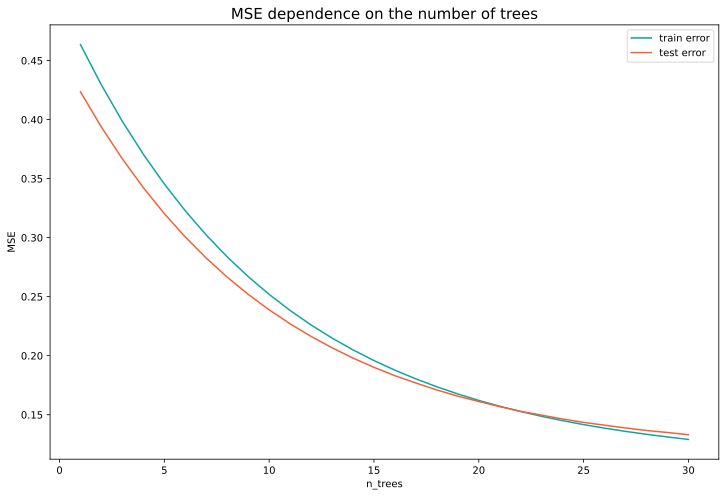

In [9]:
plt.figure(figsize=(12, 8))
plt.plot(number_of_trees, mse_train_trees, color='#0CA4A5', label='train error')
plt.plot(number_of_trees, mse_test_trees, color='#F46036', label='test error')
plt.title('MSE dependence on the number of trees', size=15)
plt.xlabel('n_trees')
plt.ylabel('MSE' )
plt.legend()

In [10]:
n_trees = 10
eta = 0.04
max_depths = list(range(1, 10))

mse_train_deeps = []
mse_test_deeps = []

for depth in max_depths:
  trees, train_errors, test_errors = gb_fit(n_trees, depth, X_train, X_test, y_train, y_test, eta)

  train_prediction = gb_predict(X_train, trees, eta)
  test_prediction = gb_predict(X_test, trees, eta)

  train_err = mean_squared_error(y_train, train_prediction)
  mse_train_deeps.append(train_err)

  test_err = mean_squared_error(y_test, test_prediction)
  mse_test_deeps.append(test_err)

mse_train_deeps, mse_test_deeps

([0.28669183251991587,
  0.28444602950978964,
  0.28087520293770035,
  0.276668942703003,
  0.27283122962723966,
  0.2694914859159373,
  0.26425971000560056,
  0.2618073014487229,
  0.2552075706429884],
 [0.26971812659544575,
  0.2671795111865833,
  0.2682204690001743,
  0.26706511597712906,
  0.26726481489922344,
  0.26675566010469764,
  0.26431163182607964,
  0.26547712550635555,
  0.2613176616607953])

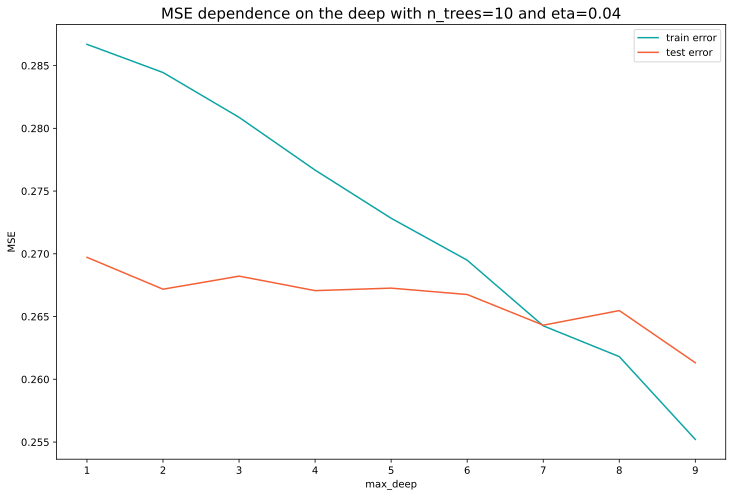

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(max_depths, mse_train_deeps, color='#0CA4A5', label='train error')
plt.plot(max_depths, mse_test_deeps, color='#F46036', label='test error')
plt.title(f'MSE dependence on the deep with n_trees={n_trees} and eta={eta}', size=15)
plt.xlabel('max_deep')
plt.ylabel('MSE')
plt.legend()

__2*.__ Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.


In [12]:
def stochastic_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta, size=1):

    np.random.seed(1234)
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []

    # Считаем количество объектов для обучения
    objects = int(size * len(X_train))
    
    for i in range(n_trees):

        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            sample_index = np.random.randint(0, len(X_train), size=objects)

            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train[sample_index], residual(y_train[sample_index], target[sample_index]))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [13]:
# Обучим модель градиентного бустинга
n_trees = 30
trees, train_errors, test_errors = gb_fit(n_trees, 4, X_train, X_test, y_train, y_test, eta=0.05)

# Обучим модель стохастического градиентного бустинга
trees_stochastic, train_errors_stochastic, test_errors_stochastic = stochastic_gb_fit(n_trees, 4, X_train, X_test, y_train, y_test, eta=0.05, size=0.5)


test_errors, test_errors_stochastic

([0.45666666666666667,
  0.4235812601608181,
  0.3931197148781992,
  0.3661928117082304,
  0.3419712619291315,
  0.3200584429141988,
  0.30045218248362715,
  0.28228711885168123,
  0.2662538229405525,
  0.25144743322502205,
  0.23822890576013478,
  0.22620987280681193,
  0.21527053798597412,
  0.20539575213785974,
  0.19659927002433983,
  0.1884663563131668,
  0.1813067180785958,
  0.17471948608060922,
  0.16886975081176114,
  0.16323666233056983,
  0.1584826622887539,
  0.15395800389585435,
  0.15026041391782177,
  0.1461684372135525,
  0.14318139555788245,
  0.13994925226307983,
  0.1374581921490807,
  0.13527015754781269,
  0.13279846121490607,
  0.1309603062423747],
 [0.45666666666666667,
  0.4235812601608181,
  0.3908215202488635,
  0.364197012681076,
  0.34011964263062117,
  0.3178373940967242,
  0.2967992291235488,
  0.2793057351062734,
  0.2625986282970051,
  0.24854170685391674,
  0.23399122052317517,
  0.22245004837134574,
  0.21164082598826903,
  0.20133613550887808,
  0.192

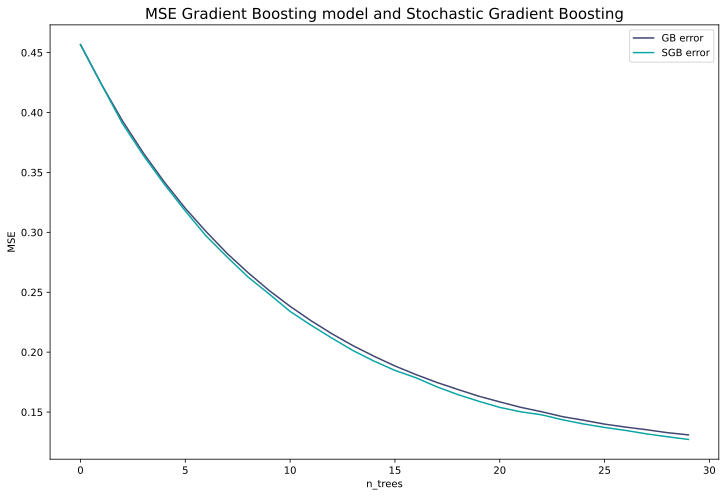

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(list(range(n_trees)), test_errors,  color='#414770', label='GB error')
plt.plot(list(range(n_trees)), test_errors_stochastic, color='#0CA4A5', label='SGB error')
plt.title('MSE Gradient Boosting model and Stochastic Gradient Boosting', size=15)
plt.xlabel('n_trees')
plt.ylabel('MSE' )
plt.legend()


__3*.__ Оптимизировать процесс обучения градиентного бустинга, чтобы он занимал меньше времени.

In [15]:
def gb_predict_optimized(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
    predictions = np.array(
    [np.sum([eta * alg.predict([x])[0] for alg in np.array(trees_list)]) for x in X]
)
    return predictions

In [16]:
%time 
gb_predict(X_train, trees, eta=0.04)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 31 µs


array([0.0554928 , 0.0215853 , 0.59460829, 0.0554928 , 0.5359801 ,
       0.51895082, 0.61007996, 0.55705475, 0.50385224, 0.0554928 ,
       0.01800203, 0.00604306, 0.06797981, 0.53833188, 0.5359801 ,
       0.53269197, 0.0554928 , 0.09329822, 0.53965608, 0.08685401,
       0.3402356 , 0.53833188, 0.0554928 , 0.08685401, 0.01800203,
       0.50385224, 0.5359801 , 0.57649588, 0.04353383, 0.0721573 ,
       0.04353383, 0.09329822, 0.53965608, 0.08685401, 0.53965608,
       0.55937588, 0.53965608, 0.24539546, 0.55937588, 0.58145003,
       0.61007996, 0.50385224, 0.24271242, 0.53269197, 0.22211653,
       0.43527389, 0.24011141, 0.50385224, 0.04691573, 0.61007996,
       0.30151996, 0.05119452, 0.53076424, 0.04353383, 0.53965608,
       0.55999917, 0.00604306, 0.09329822, 0.5359801 , 0.0554928 ,
       0.09329822, 0.0554928 , 0.43986646, 0.58145003, 0.51895082,
       0.12649091, 0.02864834, 0.53965608, 0.04353383, 0.47149122,
       0.55705475, 0.53076424, 0.5359801 , 0.02598724, 0.05549

In [17]:
%time 
gb_predict_optimized(X_train, trees, eta=0.04)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


array([0.0554928 , 0.0215853 , 0.59460829, 0.0554928 , 0.5359801 ,
       0.51895082, 0.61007996, 0.55705475, 0.50385224, 0.0554928 ,
       0.01800203, 0.00604306, 0.06797981, 0.53833188, 0.5359801 ,
       0.53269197, 0.0554928 , 0.09329822, 0.53965608, 0.08685401,
       0.3402356 , 0.53833188, 0.0554928 , 0.08685401, 0.01800203,
       0.50385224, 0.5359801 , 0.57649588, 0.04353383, 0.0721573 ,
       0.04353383, 0.09329822, 0.53965608, 0.08685401, 0.53965608,
       0.55937588, 0.53965608, 0.24539546, 0.55937588, 0.58145003,
       0.61007996, 0.50385224, 0.24271242, 0.53269197, 0.22211653,
       0.43527389, 0.24011141, 0.50385224, 0.04691573, 0.61007996,
       0.30151996, 0.05119452, 0.53076424, 0.04353383, 0.53965608,
       0.55999917, 0.00604306, 0.09329822, 0.5359801 , 0.0554928 ,
       0.09329822, 0.0554928 , 0.43986646, 0.58145003, 0.51895082,
       0.12649091, 0.02864834, 0.53965608, 0.04353383, 0.47149122,
       0.55705475, 0.53076424, 0.5359801 , 0.02598724, 0.05549